# Final Project
Tackling Long-Tail Distribution Problem

## 0. Base Setting

In [1]:
import torch


model_to_use = "Three_Stage_Classifier"
# Base_Classifier, LDAM_Classifier, Three_stage_Classifier

if model_to_use.lower() == "three_stage_classifier":
    use_scl = True

## 1. Dataset Load

In [2]:
torch.manual_seed(42)

In [3]:
from data.dataset import get_dataloader

train_loader, test_loader, cls_num_list = get_dataloader(mode = "unbalanced", use_scl=use_scl)


Files already downloaded and verified


## 2. Create Model and Set Config

In [4]:
from models.model import *
from configs._config_ import *

if model_to_use.lower() == "base_classifier":
    model = CifarResNet18(use_norm=False)
    config = create_config(model)
elif model_to_use.lower() == "ldam_classifier":
    model = CifarResNet18(use_norm=True)
    config = create_config(model, cls_num_list)
elif model_to_use.lower() == "three_stage_classifier":
    model = CifarResNet18_ThreeStage(cls_num_list=cls_num_list)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

CifarResNet18_ThreeStage(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 3. Train

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)

cuda:0


In [7]:
resume_training = True  # 이어서 학습할지 여부
start_from_stage = 3  # 몇 번 stage부터 시작할지 (1, 2, 3)

stage1_model_path = "./models_path/stage1_SCL_only.pth"
stage2_model_path = "./models_path/stage2_LDAM.pth"

# 학습 실행
from trainer.train import myTrainer, three_stage_trainer

train_losses = list()
test_losses = list()

if model_to_use.lower() == "three_stage_classifier":
    if resume_training:
        # 이어서 학습
        if start_from_stage == 2:
            train_losses, test_losses = three_stage_trainer(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                device=device,
                cls_num_list=cls_num_list,
                start_stage=2,
                load_stage1_path=stage1_model_path
            )
        elif start_from_stage == 3:
            train_losses, test_losses = three_stage_trainer(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                device=device,
                cls_num_list=cls_num_list,
                start_stage=3,
                load_stage2_path=stage2_model_path
            )
    else:
        train_losses, test_losses = three_stage_trainer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            device=device,
            cls_num_list=cls_num_list
        )
else:
    train_losses, test_losses = myTrainer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        config=config
    )

=== Loading Stage 2 model from ./models_path/stage2_LDAM.pth ===
Stage 2 model loaded successfully!

 === Stage3 Training Start ===


d:\code\DeepLearningLab\project\DeepLab_final_project\trainer\train.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_stage2_path))

[Epoch 1/60] Train Loss: 4.0828 | Test Loss: 3.8574
[Best Model Saved!] Stage 3
[Epoch 2/60] Train Loss: 3.1937 | Test Loss: 3.4176
[Best Model Saved!] Stage 3
[Epoch 3/60] Train Loss: 2.7200 | Test Loss: 3.1601
[Best Model Saved!] Stage 3
[Epoch 4/60] Train Loss: 2.4426 | Test Loss: 2.9861
[Best Model Saved!] Stage 3
[Epoch 5/60] Train Loss: 2.2624 | Test Loss: 2.8397
[Best Model Saved!] Stage 3
[Epoch 6/60] Train Loss: 2.1352 | Test Loss: 2.7445
[Best Model Saved!] Stage 3
[Epoch 7/60] Train Loss: 2.0334 | Test Loss: 2.6686
[Best Model Saved!] Stage 3
[Epoch 8/60] Train Loss: 1.9519 | Test Loss: 2.5935
[Best Model Saved!] Stage 3
[Epoch 9/60] Train Loss: 1.8873 | Test Loss: 2.5474
[Best Model Saved!] Stage 3
[Epoch 10/60] Train Loss: 1.8373 | Test Loss: 2.4947
[Best Model Saved!] Stage 3
[Epoch 11/60] Train Loss: 1.7893 | Test Loss: 2.4485
[Best Model Saved!] Stage 3
[Epoch 12/60] Train Loss: 1.7581 | Test Loss: 2.4172
[Best Model Saved!] Stage 3
[Epoch 13/60] Train Loss: 1.7245 | Te

In [9]:
import numpy as np

def compute_intra_class_variance(features, labels, num_classes=100):
        variances = []
        for c in range(num_classes):
            class_mask = (labels == c)
            if class_mask.sum() > 1:
                class_features = features[class_mask]
                class_center = class_features.mean(dim=0)
                variance = ((class_features - class_center) ** 2).sum(dim=1).mean()
                variances.append(variance.item())
        return np.mean(variances)

def compute_inter_class_distance(features, labels, num_classes=100):
    class_centers = []
    for c in range(num_classes):
        mask = (labels == c)
        if mask.sum() > 0:
            class_feat = features[mask]
            center = class_feat.mean(dim=0)
            class_centers.append(center)
    class_centers = torch.stack(class_centers, dim=0)  # (C, D)
    # 모든 클래스 중심 간 거리 평균
    return torch.pdist(class_centers, p=2).mean().item()

with torch.no_grad():
    imgs, lbls = next(iter(train_loader))
    imgs = imgs[0].cuda()  # SupCon이면 [B, 2, C, H, W] 형태 → 첫 view 사용
    labels = lbls.cuda()

    f = F.normalize(model.projection_head(model.encoder(imgs).flatten(1)), dim=1)

    intra = compute_intra_class_variance(f, labels, num_classes=100)
    inter = compute_inter_class_distance(f, labels, num_classes=100)

    print(f"Intra: {intra:.3f}, Inter: {inter:.3f}, Inter/Intra: {inter / (intra + 1e-8):.2f}")

Intra: 0.022, Inter: 0.174, Inter/Intra: 7.73


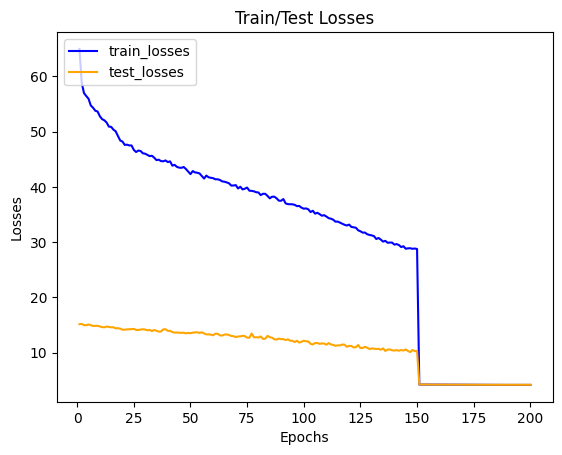

In [ ]:
import matplotlib.pyplot as plt

X = [i+1 for i in range(len(train_losses))]

plt.plot(X, train_losses, color="blue", label = "train_losses")
plt.plot(X, test_losses, color="orange", label = "test_losses")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc="upper left")
plt.title("Train/Test Losses")

plt.show()

In [8]:
# Final_project.ipynb에 추가할 셀
from metrics.metric import evaluate_stage3_model, top_1_metric

# Stage3 최종 모델 로드
final_model = CifarResNet18_ThreeStage(cls_num_list=cls_num_list)
final_model.load_state_dict(torch.load("./models_path/stage3_CSE.pth"))
final_model = final_model.to(device)

# 1. 전체 모델 및 개별 분류기 성능 평가
print("=== 전체 테스트셋 평가 ===")
overall_acc, ldam_acc, cse_acc = evaluate_stage3_model(final_model, test_loader, device)

# 2. Head/Mid/Tail 각 그룹별 성능 평가
print("\n=== Head/Mid/Tail 성능 평가 ===")
(_, head_test), (_, mid_test), (_, tail_test) = get_dataloader(split=True)

# 기존 함수 활용하되 use_scl=False로 설정
head_acc = top_1_metric(final_model, head_test, device, use_scl=use_scl)
mid_acc = top_1_metric(final_model, mid_test, device, use_scl=use_scl)
tail_acc = top_1_metric(final_model, tail_test, device, use_scl=use_scl)
print(f"[Head Accuracy] {head_acc:.2f}, [Mid Accuracy] {mid_acc:.2f}, [Tail Accuracy] {tail_acc:.2f}")

C:\Users\sttar\AppData\Local\Temp\ipykernel_30312\1227285252.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("./models_path/stage3

=== 전체 테스트셋 평가 ===
전체 모델 정확도: 60.76%
LDAM 분류기 정확도: 62.06%
CSE 분류기 정확도: 57.42%

=== Head/Mid/Tail 성능 평가 ===
Files already downloaded and verified
[Head Accuracy] 74.41, [Mid Accuracy] 64.55, [Tail Accuracy] 42.91


In [7]:
from metrics.metric import *

model_t = CifarResNet18_ThreeStage(cls_num_list=cls_num_list);                      t_save_path = "./models_path/stage3_CSE.pth"
# model_v = CifarResNet18();                      v_save_path = "./models/Base_balanced.pth"
# model_b = CifarResNet18();                       b_save_path = "./models/Base_balanced.pth"

model_t.load_state_dict(torch.load(t_save_path))
# model_v.load_state_dict(torch.load(v_save_path))
# model_b.load_state_dict(torch.load(b_save_path))
model_t = model_t.to(device);   
# model_v = model_v.to(device);   model_b = model_b.to(device)

_, test_loader_eval, _ = get_dataloader(mode="unbalanced", use_scl=False)

top_1_acc = top_1_metric(model_t, test_loader_eval, device, use_scl)
# relative_acc = relative_accuracy(model_t, model_v, model_b, test_loader, device)
# print(f"[Top-1 Accuracy] {top_1_acc:.4f}, [Relative Accuracy] {relative_acc:.4f}")
print(top_1_acc)

C:\Users\sttar\AppData\Local\Temp\ipykernel_24812\260165759.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_t.load_state_dict(torch.load(t_save_path))


Files already downloaded and verified
62.38


In [8]:
from metrics.metric import *

(_, head_test), (_, mid_test), (_, tail_test) = get_dataloader(split=True)
head_acc = top_1_metric(model_t, head_test, device, use_scl)
mid_acc = top_1_metric(model_t, mid_test, device, use_scl)
tail_acc = top_1_metric(model_t, tail_test, device, use_scl)
print(f"[Head Accuracy] {head_acc:.4f}, [Mid Accuracy] {mid_acc:.4f}, [Tail Accuracy] {tail_acc:.4f}")

Files already downloaded and verified
[Head Accuracy] 73.4118, [Mid Accuracy] 65.8182, [Tail Accuracy] 47.5758


In [15]:
from metrics.metric import *

v_acc = top_1_metric(model_t, test_loader, device)
print(v_acc)

TypeError: top_1_metric() missing 1 required positional argument: 'use_scl'